# Math 448 Term Project 

#### Project Progress Report II

<p>- Khalid Mehtab Khan, Naisarg Halvadiya

#### Importing Packages

In [1]:
# Import the required libraries here

import pandas as pd
import ISLP
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from ISLP import confusion_table
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#### Read the dataset

In [2]:
# Load Dataset 

final_dataset_refined = pd.read_pickle('fromSFOflight_refined.pkl')

In [3]:
final_dataset_refined.head()

,searchDate,flightDate,destinationAirport,travelDuration,elapsedDays,isRefundable,isBasicEconomy,isNonStop,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsArrivalTimeRaw,segmentsDistance,searchDay,flightDay,segmentsAirlineName,segmentsDurationInSeconds,daysUntilFlight
7514,2022-04-16,2022-04-17,ATL,PT6H28M,0.0,False,False,False,370.6,2.0,2193.0,2022-04-17T06:00:00.000-07:00||2022-04-17T12:2...,2022-04-17T11:35:00.000-05:00||2022-04-17T15:2...,1468||725,Saturday,Sunday,American Airlines||American Airlines,12900||7140,1
7515,2022-04-16,2022-04-17,ATL,PT6H45M,0.0,False,False,False,370.6,5.0,2332.0,2022-04-17T00:55:00.000-07:00||2022-04-17T07:3...,2022-04-17T06:31:00.000-05:00||2022-04-17T10:4...,1641||691,Saturday,Sunday,United||United,12960||7500,1
7516,2022-04-16,2022-04-17,ATL,PT6H47M,0.0,False,False,False,370.6,4.0,2161.0,2022-04-17T12:55:00.000-07:00||2022-04-17T17:4...,2022-04-17T16:34:00.000-06:00||2022-04-17T22:4...,954||1207,Saturday,Sunday,United||United,9540||10620,1
7517,2022-04-16,2022-04-17,ATL,PT6H51M,0.0,False,False,False,370.6,3.0,2236.0,2022-04-17T12:37:00.000-07:00||2022-04-17T15:5...,2022-04-17T14:35:00.000-07:00||2022-04-17T22:2...,652||1584,Saturday,Sunday,American Airlines||American Airlines,7080||12960,1
7518,2022-04-16,2022-04-17,ATL,PT6H56M,0.0,False,False,False,370.6,6.0,2193.0,2022-04-17T13:57:00.000-07:00||2022-04-17T20:4...,2022-04-17T19:29:00.000-05:00||2022-04-17T23:5...,1468||725,Saturday,Sunday,American Airlines||American Airlines,12720||7620,1


In [4]:
final_dataset_refined.dtypes

searchDate                   datetime64[ns]
flightDate                   datetime64[ns]
destinationAirport                   object
travelDuration                       object
elapsedDays                         float64
isRefundable                           bool
isBasicEconomy                         bool
isNonStop                              bool
totalFare                           float64
seatsRemaining                      float64
totalTravelDistance                 float64
segmentsDepartureTimeRaw             object
segmentsArrivalTimeRaw               object
segmentsDistance                     object
searchDay                            object
flightDay                            object
segmentsAirlineName                  object
segmentsDurationInSeconds            object
daysUntilFlight                       int64
dtype: object

In [5]:
final_dataset_refined.columns

Index(['searchDate', 'flightDate', 'destinationAirport', 'travelDuration',
       'elapsedDays', 'isRefundable', 'isBasicEconomy', 'isNonStop',
       'totalFare', 'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw',
       'segmentsDistance', 'searchDay', 'flightDay', 'segmentsAirlineName',
       'segmentsDurationInSeconds', 'daysUntilFlight'],
      dtype='object')

#### Feature Engineering

From above, the list of features that we would like to explore modeling with are as follows:

- daysUntilFlight: Shows the number of days until the departure date (already have)
- isRefundable: Tells whether or not the ticket booked is refundable (already have)
- isNonStop: Tells whether or not the flight is non-stop from the origin to the destination (already have)
- seatsRemaining: Shows the number of empty/vacant/unbooked seats in the flight from the source to destination (already have)
- isWeekendSearchDay: Shows whether the day on which this flight was searched/booked was a weekend or not (Boolean value) (code written)
- isWeekendFlightDay: Shows whether the day of the flight was a weekend or not (Boolean value) (code written)
- isMultipleCarrier: A boolean value indicating the journey having multiple airline carriers between the source and the desitnation (code written)
- CarrierCode: Code assigned to each unique carrier and in case of multiple carriers, we have decided to sum the squares of their Codes to avoide any clashes
- totalTravel Distance: The amount of miles flown by the flight (already have)
- Departure time: The time of the day when the flight departed. In case of multiple carrier intinerary, the departure time of the originating flight is considered

In [6]:
# Define a function that helps find whether a day is a weekened or not
def isWeekend(searchDay):
    if (searchDay in ['Saturday','Sunday']):
        return 1
    else:
        return 0
    
# Define a function that helps find if an intinerary has multiple carriers or not
def multiple_name(segment):
    if "||" in segment:
        parts = segment.split('||')
        val = parts[0]
        for p in parts:
            if p != val:
                return 1        
        return 0
    else:
        return 0   
    


In [7]:
# From the search and flight days, derive two new columns, to indicated weekend presence respectively
final_dataset_refined['isWeekendSearchDay'] = final_dataset_refined.searchDay.apply(isWeekend)
final_dataset_refined['isWeekendFlightDay'] = final_dataset_refined.flightDay.apply(isWeekend)

# From the segement airline name, find out whether it has multiple carriers or not
final_dataset_refined['Multiple_Carriers'] = final_dataset_refined['segmentsAirlineName'].apply(multiple_name)

In [8]:
# Function to clean and split the airline names
def clean_and_split(airline_string):
    return set(airline.strip() for airline in airline_string.split('||'))

# Apply the cleaning function and find unique airlines
final_dataset_refined['distinct_airlines'] = final_dataset_refined['segmentsAirlineName'].apply(clean_and_split)
unique_airlines = set().union(*final_dataset_refined['distinct_airlines'])

# Sort the unique airlines and assign numbers starting from 1
sorted_unique_airlines = sorted(unique_airlines)
airline_numbers = {airline: idx + 1 for idx, airline in enumerate(sorted_unique_airlines)}

# Store the combinations and codes in a dictionary for later use
combinations_codes = {}

# Function to calculate the combination code
def calculate_combination_code(airlines_set):
    # If only one unique airline, return its assigned number, else sum the squares of the assigned numbers
    if len(airlines_set) == 1:
        code = airline_numbers[next(iter(airlines_set))]
        combinations_codes[' || '.join(airlines_set)] = code
        return code
    else:
        code = sum(airline_numbers[airline] ** 2 for airline in airlines_set)
        combinations_codes[' || '.join(airlines_set)] = code
        return code

final_dataset_refined['combination_code'] = final_dataset_refined['distinct_airlines'].apply(calculate_combination_code)

# Display the unique airlines and their assigned codes
unique_airlines_with_codes = pd.DataFrame(list(airline_numbers.items()), columns=['Airline', 'Code']).sort_values(by='Code')
unique_airlines_with_codes.set_index('Code', inplace=True)

unique_airlines_with_codes, final_dataset_refined[['segmentsAirlineName', 'combination_code']].head(), combinations_codes

(                       Airline
 Code                          
 1              Alaska Airlines
 2            American Airlines
 3                     Cape Air
 4                        Delta
 5            Frontier Airlines
 6              JetBlue Airways
 7                 Key Lime Air
 8     Southern Airways Express
 9         Sun Country Airlines
 10                      United,
                        segmentsAirlineName  combination_code
 7514  American Airlines||American Airlines                 2
 7515                        United||United                10
 7516                        United||United                10
 7517  American Airlines||American Airlines                 2
 7518  American Airlines||American Airlines                 2,
 {'American Airlines': 2,
  'United': 10,
  'JetBlue Airways': 6,
  'Delta': 4,
  'Alaska Airlines || Delta': 17,
  'Frontier Airlines': 5,
  'Sun Country Airlines': 9,
  'Alaska Airlines': 1,
  'United || Alaska Airlines': 101,
  'United || 

In [9]:
# First, let's group the dataset by 'combination_code' and check if any code corresponds to more than one distinct 'segmentsAirlineName'

# This function will aggregate all unique 'segmentsAirlineName' into a set for each 'combination_code'
grouped = final_dataset_refined.groupby('combination_code')['segmentsAirlineName'].agg(set)

# Now we'll find the 'combination_code' values that have more than one distinct 'segmentsAirlineName'
duplicate_combinations = grouped[grouped.apply(len) > 1]

duplicate_combinations if not duplicate_combinations.empty else 0

combination_code
1      {Alaska Airlines, Alaska Airlines||Alaska Airl...
2      {American Airlines||American Airlines, America...
4             {Delta||Delta, Delta||Delta||Delta, Delta}
5      {Frontier Airlines||Frontier Airlines||Frontie...
6      {JetBlue Airways, JetBlue Airways||JetBlue Air...
10     {United||United, United||United||United, Unite...
17     {Alaska Airlines||Delta||Delta, Delta||Alaska ...
101    {United||Alaska Airlines||United, Alaska Airli...
104    {United||American Airlines||American Airlines,...
116    {Delta||Delta||United||United, Delta||United, ...
117    {United||Alaska Airlines||Delta, Alaska Airlin...
Name: segmentsAirlineName, dtype: object

In [10]:
final_dataset_refined['journeyStartTime'] = final_dataset_refined['segmentsDepartureTimeRaw'].str.split('\|\|').str[0]
final_dataset_refined['journeyStartTime'] = final_dataset_refined['journeyStartTime'].str.split('T').str[1]
final_dataset_refined['journeyStartTime'] = final_dataset_refined['journeyStartTime'].str.split('-').str[0]   
final_dataset_refined['journeyStartTime'] = final_dataset_refined['journeyStartTime'].str.split('.').str[0]



<>:1: SyntaxWarning: invalid escape sequence '\|'
<>:1: SyntaxWarning: invalid escape sequence '\|'
/var/folders/6f/0y8g_m9j7rz31rjlcl79n7gh0000gn/T/ipykernel_2029/1891740342.py:1: SyntaxWarning: invalid escape sequence '\|'
  final_dataset_refined['journeyStartTime'] = final_dataset_refined['segmentsDepartureTimeRaw'].str.split('\|\|').str[0]


In [11]:
val1 = final_dataset_refined['journeyStartTime'].str.split(":").str[0]
val2 = final_dataset_refined['journeyStartTime'].str.split(":").str[1]
final_dataset_refined['journeyStartTime'] = val1.apply(lambda x : int(x)) + val2.apply(lambda x : float(x)/60)

In [12]:
final_dataset_refined

,searchDate,flightDate,destinationAirport,travelDuration,elapsedDays,isRefundable,isBasicEconomy,isNonStop,totalFare,seatsRemaining,...,flightDay,segmentsAirlineName,segmentsDurationInSeconds,daysUntilFlight,isWeekendSearchDay,isWeekendFlightDay,Multiple_Carriers,distinct_airlines,combination_code,journeyStartTime
7514,2022-04-16,2022-04-17,ATL,PT6H28M,0.0,False,False,False,370.60,2.0,...,Sunday,American Airlines||American Airlines,12900||7140,1,1,1,0,{American Airlines},2,6.000000
7515,2022-04-16,2022-04-17,ATL,PT6H45M,0.0,False,False,False,370.60,5.0,...,Sunday,United||United,12960||7500,1,1,1,0,{United},10,0.916667
7516,2022-04-16,2022-04-17,ATL,PT6H47M,0.0,False,False,False,370.60,4.0,...,Sunday,United||United,9540||10620,1,1,1,0,{United},10,12.916667
7517,2022-04-16,2022-04-17,ATL,PT6H51M,0.0,False,False,False,370.60,3.0,...,Sunday,American Airlines||American Airlines,7080||12960,1,1,1,0,{American Airlines},2,12.616667
7518,2022-04-16,2022-04-17,ATL,PT6H56M,0.0,False,False,False,370.60,6.0,...,Sunday,American Airlines||American Airlines,12720||7620,1,1,1,0,{American Airlines},2,13.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163707,2022-10-05,2022-11-11,PHL,PT8H33M,0.0,False,False,False,477.61,2.0,...,Friday,United||United,13620||11820,37,0,0,0,{United},10,5.183333
163708,2022-10-05,2022-11-11,PHL,PT7H23M,0.0,False,False,False,488.60,4.0,...,Friday,Delta||Delta,12840||9780,37,0,0,0,{Delta},4,0.416667
163709,2022-10-05,2022-11-11,PHL,PT7H26M,0.0,False,False,False,497.60,2.0,...,Friday,Alaska Airlines||United,15480||7380,37,0,0,1,"{United, Alaska Airlines}",101,10.500000
163710,2022-10-05,2022-11-11,PHL,PT8H12M,0.0,False,False,False,567.60,4.0,...,Friday,United||United,13200||12120,37,0,0,0,{United},10,0.583333


In [13]:
# For 'searchDayInt' and 'flightDayInt', your current approach is good
# No changes needed here
final_dataset_refined['searchDayInt'] = final_dataset_refined['searchDay'].apply(
    lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x))
final_dataset_refined['flightDayInt'] = final_dataset_refined['flightDay'].apply(
    lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x))

In [14]:
# For 'desitnationAirportCode' it looks like there might be a typo, should be 'destinationAirportCode'
final_dataset_refined['destinationAirportCode'] = final_dataset_refined['destinationAirport'].apply(
    lambda x: ['ATL', 'BOS', 'CLT', 'DEN', 'DFW', 'DTW', 'EWR', 'IAD', 'JFK', 'LAX', 'LGA', 'MIA', 'OAK', 'ORD', 'PHL'].index(x))

In [15]:
final_dataset_refined.head(10)

,searchDate,flightDate,destinationAirport,travelDuration,elapsedDays,isRefundable,isBasicEconomy,isNonStop,totalFare,seatsRemaining,...,daysUntilFlight,isWeekendSearchDay,isWeekendFlightDay,Multiple_Carriers,distinct_airlines,combination_code,journeyStartTime,searchDayInt,flightDayInt,destinationAirportCode
7514,2022-04-16,2022-04-17,ATL,PT6H28M,0.0,False,False,False,370.6,2.0,...,1,1,1,0,{American Airlines},2,6.000000,5,6,0
7515,2022-04-16,2022-04-17,ATL,PT6H45M,0.0,False,False,False,370.6,5.0,...,1,1,1,0,{United},10,0.916667,5,6,0
7516,2022-04-16,2022-04-17,ATL,PT6H47M,0.0,False,False,False,370.6,4.0,...,1,1,1,0,{United},10,12.916667,5,6,0
7517,2022-04-16,2022-04-17,ATL,PT6H51M,0.0,False,False,False,370.6,3.0,...,1,1,1,0,{American Airlines},2,12.616667,5,6,0
7518,2022-04-16,2022-04-17,ATL,PT6H56M,0.0,False,False,False,370.6,6.0,...,1,1,1,0,{American Airlines},2,13.950000,5,6,0
7519,2022-04-16,2022-04-17,ATL,PT7H13M,0.0,False,False,False,370.6,2.0,...,1,1,1,0,{American Airlines},2,12.000000,5,6,0
7520,2022-04-16,2022-04-17,ATL,PT7H15M,0.0,False,False,False,370.6,1.0,...,1,1,1,0,{United},10,9.250000,5,6,0
7521,2022-04-16,2022-04-17,ATL,PT7H17M,1.0,False,False,False,370.6,1.0,...,1,1,1,0,{United},10,23.916667,5,6,0
7522,2022-04-16,2022-04-17,ATL,PT7H18M,0.0,False,False,False,370.6,2.0,...,1,1,1,0,{United},10,7.833333,5,6,0
7523,2022-04-16,2022-04-17,ATL,PT7H27M,0.0,False,False,False,370.6,7.0,...,1,1,1,0,{American Airlines},2,6.350000,5,6,0


In [16]:
final_dataset_refined.to_pickle("finalDataset.pkl")

In [23]:
final_dataset = pd.read_pickle('finalDataset.pkl')

In [24]:
final_dataset.columns

Index(['searchDate', 'flightDate', 'destinationAirport', 'travelDuration',
       'elapsedDays', 'isRefundable', 'isBasicEconomy', 'isNonStop',
       'totalFare', 'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw',
       'segmentsDistance', 'searchDay', 'flightDay', 'segmentsAirlineName',
       'segmentsDurationInSeconds', 'daysUntilFlight', 'isWeekendSearchDay',
       'isWeekendFlightDay', 'Multiple_Carriers', 'distinct_airlines',
       'combination_code', 'journeyStartTime', 'searchDayInt', 'flightDayInt',
       'destinationAirportCode'],
      dtype='object')

In [25]:
final_dataset.dtypes

searchDate                   datetime64[ns]
flightDate                   datetime64[ns]
destinationAirport                   object
travelDuration                       object
elapsedDays                         float64
isRefundable                           bool
isBasicEconomy                         bool
isNonStop                              bool
totalFare                           float64
seatsRemaining                      float64
totalTravelDistance                 float64
segmentsDepartureTimeRaw             object
segmentsArrivalTimeRaw               object
segmentsDistance                     object
searchDay                            object
flightDay                            object
segmentsAirlineName                  object
segmentsDurationInSeconds            object
daysUntilFlight                       int64
isWeekendSearchDay                    int64
isWeekendFlightDay                    int64
Multiple_Carriers                     int64
distinct_airlines               

In [26]:
pd.set_option('display.max_columns', None)

In [27]:
# searchDate, flightDate, elapsedDays, isRefundable, isBasicEconomy, isNonStop, seatsRemaining, totalTravelDistance, daysUntilFlight, isWeekendSearchDay, isWeekendFlightDay, Multiple_carriers, combination_code, journeyStartTime, searchDayInt, flightDayInt, destinationAirportCode

In [28]:
final_dataset = final_dataset[['searchDate', 'flightDate', 'elapsedDays', 'isRefundable', 'isBasicEconomy', 'isNonStop', 'seatsRemaining', 'totalTravelDistance', 'daysUntilFlight', 'isWeekendSearchDay', 'isWeekendFlightDay', 'Multiple_Carriers', 'combination_code', 'journeyStartTime', 'searchDayInt', 'flightDayInt', 'destinationAirportCode','totalFare']]

In [29]:
final_dataset.head()

,searchDate,flightDate,elapsedDays,isRefundable,isBasicEconomy,isNonStop,seatsRemaining,totalTravelDistance,daysUntilFlight,isWeekendSearchDay,isWeekendFlightDay,Multiple_Carriers,combination_code,journeyStartTime,searchDayInt,flightDayInt,destinationAirportCode,totalFare
7514,2022-04-16,2022-04-17,0.0,False,False,False,2.0,2193.0,1,1,1,0,2,6.000000,5,6,0,370.6
7515,2022-04-16,2022-04-17,0.0,False,False,False,5.0,2332.0,1,1,1,0,10,0.916667,5,6,0,370.6
7516,2022-04-16,2022-04-17,0.0,False,False,False,4.0,2161.0,1,1,1,0,10,12.916667,5,6,0,370.6
7517,2022-04-16,2022-04-17,0.0,False,False,False,3.0,2236.0,1,1,1,0,2,12.616667,5,6,0,370.6
7518,2022-04-16,2022-04-17,0.0,False,False,False,6.0,2193.0,1,1,1,0,2,13.950000,5,6,0,370.6


In [30]:
final_dataset.dtypes

searchDate                datetime64[ns]
flightDate                datetime64[ns]
elapsedDays                      float64
isRefundable                        bool
isBasicEconomy                      bool
isNonStop                           bool
seatsRemaining                   float64
totalTravelDistance              float64
daysUntilFlight                    int64
isWeekendSearchDay                 int64
isWeekendFlightDay                 int64
Multiple_Carriers                  int64
combination_code                   int64
journeyStartTime                 float64
searchDayInt                       int64
flightDayInt                       int64
destinationAirportCode             int64
totalFare                        float64
dtype: object

C:\Users\naisa\AppData\Local\Temp\ipykernel_43468\1801429548.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_dataset.corr()


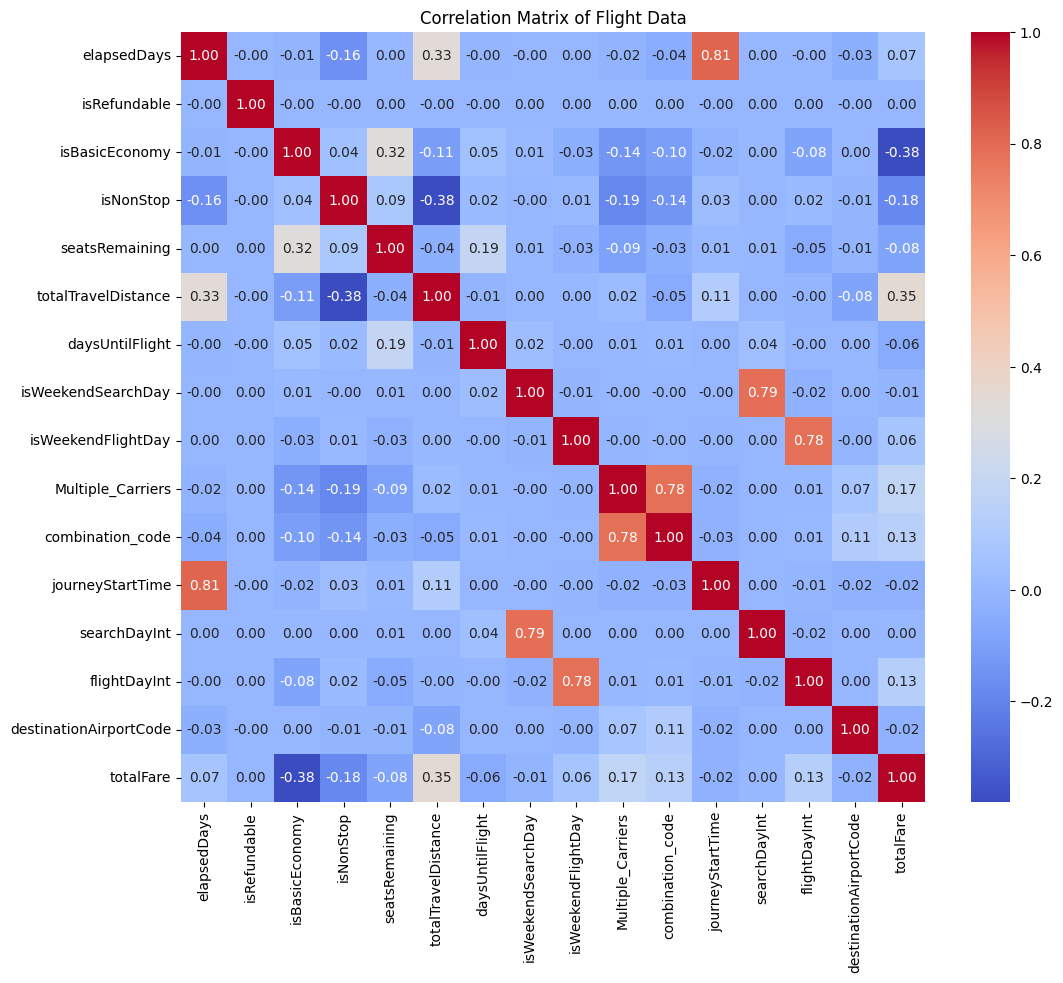

In [31]:
# Calculate the correlation matrix
corr_matrix = final_dataset.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # You can adjust the size of the figure here
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Flight Data')
plt.show()

From the correlation Matrix we can see that, totalFare

- has the highest positive correlation with totalTravelDistance and the highest negative correlation with isBasicEconomy
- is not correlated to isRefundable and searchDayInt

#### Linear Regression

We'll start of by creating a basic liner regression model with all the above predictors.

In [11]:
# Divide the dataset into train and test. Test = 25%

train_df, test_df = train_test_split(final_dataset, test_size=0.25, random_state=42)

# Print the shape of the datasets to verify the split
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (4133608, 18)
Testing set shape: (1377870, 18)


In [12]:
# Here converting datetime to the day of the year for regression purposes
train_df['searchDate'] = train_df['searchDate'].dt.dayofyear
train_df['flightDate'] = train_df['flightDate'].dt.dayofyear


In [13]:
allvars = train_df.columns.drop(['totalFare'])
design = MS(allvars)
X = design.fit_transform(train_df)
y = train_df.totalFare
glm = sm.GLM(y,
             X,)
results = glm.fit()

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              totalFare   No. Observations:              4133608
Model:                            GLM   Df Residuals:                  4133591
Model Family:                Gaussian   Df Model:                           16
Link Function:               Identity   Scale:                          32873.
Method:                          IRLS   Log-Likelihood:            -2.7361e+07
Date:                Sun, 21 Apr 2024   Deviance:                   1.3588e+11
Time:                        22:43:50   Pearson chi2:                 1.36e+11
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4106
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                461.4407      0.681    677.314      0.000     460.105     462.776
searchDate                -0.4674      0.002   -218.647      0.000      -0.472      -0.463
flightDate                -0.8294      0.002   -400.015      0.000      -0.833      -0.825
elapsedDays               -6.4326      0.357    -17.999      0.000      -7.133      -5.732
isRefundable            -152.7328    104.680     -1.459      0.145    -357.901      52.435
isBasicEconomy          -172.9706      0.295   -586.283      0.000    -173.549    -172.392
isNonStop                -28.8772      0.242   -119.349      0.000     -29.351     -28.403
seatsRemaining             7.1432      0.038    189.983      0.000       7.070       7.217
totalTravelDistance        0.0910      0.000    666.576      0.000       0.091       0.091
daysUntilFlight           -0.3619      0.004    -96.958      0.000      -0.369      -0.355
isWeekendSearchDay        -7.5251      0.317    -23.749      0.000      -8.146      -6.904
isWeekendFlightDay       -38.5689      0.326   -118.456      0.000     -39.207     -37.931
Multiple_Carriers         53.1090      0.460    115.362      0.000      52.207      54.011
combination_code           0.3660      0.006     62.270      0.000       0.355       0.378
journeyStartTime          -1.7989      0.025    -71.980      0.000      -1.848      -1.750
searchDayInt               2.1151      0.073     28.853      0.000       1.971       2.259
flightDayInt              19.0905      0.072    263.352      0.000      18.948      19.233
destinationAirportCode    -0.4604      0.021    -22.223      0.000      -0.501      -0.420
==========================================================================================
"""

- isRefundable variable has a really high p-value showcasing unimportance of this predictor in the model

Let's try to predict the values from this default values and see the results

In [62]:
def fit_and_evaluate_regression_model(data, target_column):
    # Splitting the dataset
    train_df, test_df = train_test_split(data, test_size=0.25, random_state=42)

    # Prepare the training data
    if 'searchDate' in train_df.columns and 'flightDate' in train_df.columns:
         train_df['searchDate'] = train_df['searchDate'].dt.dayofyear
         train_df['flightDate'] = train_df['flightDate'].dt.dayofyear
   
    allvars = train_df.columns.drop([target_column])
    design = MS(allvars)
    X = design.fit_transform(train_df)
    y = train_df.totalFare
    glm = sm.GLM(y,
                X,)
    results = glm.fit()

    # Prepare the testing data
    if 'searchDate' in train_df.columns and 'flightDate' in test_df.columns:
        test_df['searchDate'] = test_df['searchDate'].dt.dayofyear
        test_df['flightDate'] = test_df['flightDate'].dt.dayofyear
    allvars = test_df.columns.drop([target_column])
    design = MS(allvars)
    X = design.fit_transform(test_df)
    y = test_df.totalFare

    y_pred = results.predict(X)
    # True target values
    y_test = test_df[target_column]

    # Compute metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Return metrics
    return [
        results.summary(),
        mse,
        mae,
        r2
    ]

- We can see that the values of MSE and MAE and the low R-squared value indicating the model's poor prediction
- Moodel is not capturing a large portion of the variance in the target variable. These results may indicate the need for further model tuning, feature engineering, or the exploration of different modeling techniques to improve the model's predictive performance.

In [46]:
# Example usage
# Assuming 'final_dataset' and 'totalFare' are defined elsewhere
metrics = fit_and_evaluate_regression_model(final_dataset, 'totalFare')

In [49]:
metrics[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              totalFare   No. Observations:              4133608
Model:                            GLM   Df Residuals:                  4133591
Model Family:                Gaussian   Df Model:                           16
Link Function:               Identity   Scale:                          32873.
Method:                          IRLS   Log-Likelihood:            -2.7361e+07
Date:                Sun, 21 Apr 2024   Deviance:                   1.3588e+11
Time:                        22:59:46   Pearson chi2:                 1.36e+11
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4106
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                461.4407      0.681    677.314      0.000     460.105     462.776
searchDate                -0.4674      0.002   -218.647      0.000      -0.472      -0.463
flightDate                -0.8294      0.002   -400.015      0.000      -0.833      -0.825
elapsedDays               -6.4326      0.357    -17.999      0.000      -7.133      -5.732
isRefundable            -152.7328    104.680     -1.459      0.145    -357.901      52.435
isBasicEconomy          -172.9706      0.295   -586.283      0.000    -173.549    -172.392
isNonStop                -28.8772      0.242   -119.349      0.000     -29.351     -28.403
seatsRemaining             7.1432      0.038    189.983      0.000       7.070       7.217
totalTravelDistance        0.0910      0.000    666.576      0.000       0.091       0.091
daysUntilFlight           -0.3619      0.004    -96.958      0.000      -0.369      -0.355
isWeekendSearchDay        -7.5251      0.317    -23.749      0.000      -8.146      -6.904
isWeekendFlightDay       -38.5689      0.326   -118.456      0.000     -39.207     -37.931
Multiple_Carriers         53.1090      0.460    115.362      0.000      52.207      54.011
combination_code           0.3660      0.006     62.270      0.000       0.355       0.378
journeyStartTime          -1.7989      0.025    -71.980      0.000      -1.848      -1.750
searchDayInt               2.1151      0.073     28.853      0.000       1.971       2.259
flightDayInt              19.0905      0.072    263.352      0.000      18.948      19.233
destinationAirportCode    -0.4604      0.021    -22.223      0.000      -0.501      -0.420
==========================================================================================
"""

In [48]:

print("Mean Squared error", metrics[1])
print("Mean Absolute error", metrics[2])
print("R Squared error", metrics[3])


Mean Squared error 33175.54121850534
Mean Absolute error 113.16259899178348
R Squared error 0.3433372870344288


We'll now remove the isRefundable predictor and see if there's any difference in the prediction using linear regression

- Pre Processing Part 2
1. Time Features:
We'll extract the month and the week of the year from both searchDate and flightDate. This will help us analyze trends and seasonality in the data.

2. Encoded Features:
We'll apply one-hot encoding to the destinationAirport column to transform it into a format suitable for machine learning models. This turns categorical data into a numerical format where each category becomes a new binary column.

3. Interaction Features:
We will create an interaction feature by multiplying daysUntilFlight by isWeekendSearchDay. This feature will help us understand if searching for flights on weekends close to the flight date affects fare prices differently.

In [54]:
metrics_without_isRefundable = fit_and_evaluate_regression_model(final_dataset.drop('isRefundable', axis=1), 'totalFare')

In [55]:
metrics_without_isRefundable[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              totalFare   No. Observations:              4133608
Model:                            GLM   Df Residuals:                  4133592
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                          32873.
Method:                          IRLS   Log-Likelihood:            -2.7361e+07
Date:                Sun, 21 Apr 2024   Deviance:                   1.3588e+11
Time:                        23:05:37   Pearson chi2:                 1.36e+11
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4106
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                461.4391      0.681    677.313      0.000     460.104     462.774
searchDate                -0.4674      0.002   -218.646      0.000      -0.472      -0.463
flightDate                -0.8294      0.002   -400.014      0.000      -0.833      -0.825
elapsedDays               -6.4330      0.357    -18.000      0.000      -7.133      -5.733
isBasicEconomy          -172.9706      0.295   -586.284      0.000    -173.549    -172.392
isNonStop                -28.8770      0.242   -119.348      0.000     -29.351     -28.403
seatsRemaining             7.1432      0.038    189.982      0.000       7.070       7.217
totalTravelDistance        0.0910      0.000    666.579      0.000       0.091       0.091
daysUntilFlight           -0.3619      0.004    -96.957      0.000      -0.369      -0.355
isWeekendSearchDay        -7.5252      0.317    -23.749      0.000      -8.146      -6.904
isWeekendFlightDay       -38.5692      0.326   -118.457      0.000     -39.207     -37.931
Multiple_Carriers         53.1076      0.460    115.359      0.000      52.205      54.010
combination_code           0.3661      0.006     62.272      0.000       0.355       0.378
journeyStartTime          -1.7988      0.025    -71.978      0.000      -1.848      -1.750
searchDayInt               2.1151      0.073     28.852      0.000       1.971       2.259
flightDayInt              19.0905      0.072    263.351      0.000      18.948      19.233
destinationAirportCode    -0.4604      0.021    -22.221      0.000      -0.501      -0.420
==========================================================================================
"""

In [56]:

print("Mean Squared error", metrics_without_isRefundable[1])
print("Mean Absolute error", metrics_without_isRefundable[2])
print("R Squared error", metrics_without_isRefundable[3])


Mean Squared error 33175.58385595679
Mean Absolute error 113.16280202851974
R Squared error 0.34333644308664335


There's no improvement in the results of the model.

In [65]:
metrics_some = fit_and_evaluate_regression_model(final_dataset[['totalFare','isBasicEconomy','isNonStop','Multiple_Carriers','combination_code','flightDayInt','totalTravelDistance']], 'totalFare')

In [66]:
metrics_some[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              totalFare   No. Observations:              4133608
Model:                            GLM   Df Residuals:                  4133601
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          36898.
Method:                          IRLS   Log-Likelihood:            -2.7600e+07
Date:                Mon, 22 Apr 2024   Deviance:                   1.5252e+11
Time:                        00:01:46   Pearson chi2:                 1.53e+11
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3037
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept             222.4515      0.393    565.384      0.000     221.680     223.223
isBasicEconomy       -214.4780      0.286   -749.968      0.000    -215.039    -213.917
isNonStop             -20.7718      0.250    -83.016      0.000     -21.262     -20.281
Multiple_Carriers      56.2710      0.486    115.817      0.000      55.319      57.223
combination_code        0.4350      0.006     70.203      0.000       0.423       0.447
flightDayInt           11.6059      0.048    242.024      0.000      11.512      11.700
totalTravelDistance     0.0862      0.000    643.316      0.000       0.086       0.086
=======================================================================================
"""

In [67]:

print("Mean Squared error", metrics_some[1])
print("Mean Absolute error", metrics_some[2])
print("R Squared error", metrics_some[3])


Mean Squared error 37214.8880248945
Mean Absolute error 122.33472333557546
R Squared error 0.2633841548452015


In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
# Convert 'searchDate' and 'flightDate' to datetime
final_dataset['searchDate'] = pd.to_datetime(final_dataset['searchDate'])
final_dataset['flightDate'] = pd.to_datetime(final_dataset['flightDate'])

# Extracting month and week from dates
final_dataset['searchMonth'] = final_dataset['searchDate'].dt.month
final_dataset['searchWeek'] = final_dataset['searchDate'].dt.isocalendar().week
final_dataset['flightMonth'] = final_dataset['flightDate'].dt.month
final_dataset['flightWeek'] = final_dataset['flightDate'].dt.isocalendar().week

# One-hot encoding 'destinationAirport'
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(final_dataset[['destinationAirport']])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['destinationAirport']))

# Reset index before concatenation
final_dataset.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate dataframes
final_dataset = pd.concat([final_dataset, encoded_df], axis=1)

# Creating interaction feature
final_dataset['daysUntilFlight_isWeekendSearchDay'] = final_dataset['daysUntilFlight'] * final_dataset['isWeekendSearchDay']


final_dataset.head()

,searchDate,flightDate,destinationAirport,travelDuration,elapsedDays,isRefundable,isBasicEconomy,isNonStop,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsArrivalTimeRaw,segmentsDistance,searchDay,flightDay,segmentsAirlineName,segmentsDurationInSeconds,daysUntilFlight,isWeekendSearchDay,isWeekendFlightDay,Multiple_Carriers,distinct_airlines,combination_code,journeyStartTime,searchDayInt,flightDayInt,destinationAirportCode,searchMonth,searchWeek,flightMonth,flightWeek,destinationAirport_ATL,destinationAirport_BOS,destinationAirport_CLT,destinationAirport_DEN,destinationAirport_DFW,destinationAirport_DTW,destinationAirport_EWR,destinationAirport_IAD,destinationAirport_JFK,destinationAirport_LAX,destinationAirport_LGA,destinationAirport_MIA,destinationAirport_OAK,destinationAirport_ORD,destinationAirport_PHL,daysUntilFlight_isWeekendSearchDay
0,2022-04-16,2022-04-17,ATL,PT6H28M,0.0,False,False,False,370.6,2.0,2193.0,2022-04-17T06:00:00.000-07:00||2022-04-17T12:2...,2022-04-17T11:35:00.000-05:00||2022-04-17T15:2...,1468||725,Saturday,Sunday,American Airlines||American Airlines,12900||7140,1,1,1,0,{American Airlines},2,6.000000,5,6,0,4,15,4,15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2022-04-16,2022-04-17,ATL,PT6H45M,0.0,False,False,False,370.6,5.0,2332.0,2022-04-17T00:55:00.000-07:00||2022-04-17T07:3...,2022-04-17T06:31:00.000-05:00||2022-04-17T10:4...,1641||691,Saturday,Sunday,United||United,12960||7500,1,1,1,0,{United},10,0.916667,5,6,0,4,15,4,15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2022-04-16,2022-04-17,ATL,PT6H47M,0.0,False,False,False,370.6,4.0,2161.0,2022-04-17T12:55:00.000-07:00||2022-04-17T17:4...,2022-04-17T16:34:00.000-06:00||2022-04-17T22:4...,954||1207,Saturday,Sunday,United||United,9540||10620,1,1,1,0,{United},10,12.916667,5,6,0,4,15,4,15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2022-04-16,2022-04-17,ATL,PT6H51M,0.0,False,False,False,370.6,3.0,2236.0,2022-04-17T12:37:00.000-07:00||2022-04-17T15:5...,2022-04-17T14:35:00.000-07:00||2022-04-17T22:2...,652||1584,Saturday,Sunday,American Airlines||American Airlines,7080||12960,1,1,1,0,{American Airlines},2,12.616667,5,6,0,4,15,4,15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2022-04-16,2022-04-17,ATL,PT6H56M,0.0,False,False,False,370.6,6.0,2193.0,2022-04-17T13:57:00.000-07:00||2022-04-17T20:4...,2022-04-17T19:29:00.000-05:00||2022-04-17T23:5...,1468||725,Saturday,Sunday,American Airlines||American Airlines,12720||7620,1,1,1,0,{American Airlines},2,13.950000,5,6,0,4,15,4,15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [48]:
final_dataset['isNonStop'] = final_dataset['isNonStop'].astype(int) 
final_dataset['isBasicEconomy'] = final_dataset['isBasicEconomy'].astype(int)

In [28]:
final_dataset.columns

Index(['searchDate', 'flightDate', 'destinationAirport', 'travelDuration',
       'elapsedDays', 'isRefundable', 'isBasicEconomy', 'isNonStop',
       'totalFare', 'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw',
       'segmentsDistance', 'searchDay', 'flightDay', 'segmentsAirlineName',
       'segmentsDurationInSeconds', 'daysUntilFlight', 'isWeekendSearchDay',
       'isWeekendFlightDay', 'Multiple_Carriers', 'distinct_airlines',
       'combination_code', 'journeyStartTime', 'searchDayInt', 'flightDayInt',
       'destinationAirportCode', 'searchMonth', 'searchWeek', 'flightMonth',
       'flightWeek', 'destinationAirport_ATL', 'destinationAirport_BOS',
       'destinationAirport_CLT', 'destinationAirport_DEN',
       'destinationAirport_DFW', 'destinationAirport_DTW',
       'destinationAirport_EWR', 'destinationAirport_IAD',
       'destinationAirport_JFK', 'destinationAirport_LAX',
       'destinationAirport_LGA', 'destination

In [29]:
final_dataset.dtypes

searchDate                            datetime64[ns]
flightDate                            datetime64[ns]
destinationAirport                            object
travelDuration                                object
elapsedDays                                  float64
isRefundable                                    bool
isBasicEconomy                                  bool
isNonStop                                       bool
totalFare                                    float64
seatsRemaining                               float64
totalTravelDistance                          float64
segmentsDepartureTimeRaw                      object
segmentsArrivalTimeRaw                        object
segmentsDistance                              object
searchDay                                     object
flightDay                                     object
segmentsAirlineName                           object
segmentsDurationInSeconds                     object
daysUntilFlight                               

In [20]:
pd.set_option('display.max_columns', None)

In [ ]:
# searchDate, flightDate, elapsedDays, isRefundable, isBasicEconomy, isNonStop, seatsRemaining, totalTravelDistance, daysUntilFlight, isWeekendSearchDay, isWeekendFlightDay, Multiple_carriers, combination_code, journeyStartTime, searchDayInt, flightDayInt, destinationAirportCode

In [ ]:
final_dataset = final_dataset[['searchDate', 'flightDate', 'elapsedDays', 'isRefundable', 'isBasicEconomy', 'isNonStop', 'seatsRemaining', 'totalTravelDistance', 'daysUntilFlight', 'isWeekendSearchDay', 'isWeekendFlightDay', 'Multiple_Carriers', 'combination_code', 'journeyStartTime', 'searchDayInt', 'flightDayInt', 'destinationAirportCode','totalFare']]

In [ ]:
final_dataset.head()

In [ ]:
final_dataset.dtypes

In [ ]:
# Calculate the correlation matrix
corr_matrix = final_dataset.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # You can adjust the size of the figure here
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Flight Data')
plt.show()

From the correlation Matrix we can see that, totalFare

- has the highest positive correlation with totalTravelDistance and the highest negative correlation with isBasicEconomy
- is not correlated to isRefundable and searchDayInt

#### Linear Regression

We'll start of by creating a basic liner regression model with all the above predictors.

In [ ]:
# Divide the dataset into train and test. Test = 25%

train_df, test_df = train_test_split(final_dataset, test_size=0.25, random_state=42)

# Print the shape of the datasets to verify the split
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

In [ ]:
# Here converting datetime to the day of the year for regression purposes
train_df['searchDate'] = train_df['searchDate'].dt.dayofyear
train_df['flightDate'] = train_df['flightDate'].dt.dayofyear


In [ ]:
allvars = train_df.columns.drop(['totalFare'])
design = MS(allvars)
X = design.fit_transform(train_df)
y = train_df.totalFare
glm = sm.GLM(y,
             X,)
results = glm.fit()

In [ ]:
results.summary()

- isRefundable variable has a really high p-value showcasing unimportance of this predictor in the model

Let's try to predict the values from this default values and see the results

In [ ]:
# Here converting datetime to the day of the year for regression purposes
test_df['searchDate'] = test_df['searchDate'].dt.dayofyear
test_df['flightDate'] = test_df['flightDate'].dt.dayofyear

In [ ]:
allvars = test_df.columns.drop(['totalFare'])
design = MS(allvars)
X = design.fit_transform(test_df)
y = test_df.totalFare

In [ ]:
y_pred = results.predict(X)

In [ ]:
# True target values
y_test = test_df['totalFare']

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

- We can see that the values of MSE and MAE and the low R-squared value indicating the model's poor prediction
- Moodel is not capturing a large portion of the variance in the target variable. These results may indicate the need for further model tuning, feature engineering, or the exploration of different modeling techniques to improve the model's predictive performance.

# 2. Linear Regression (Predicting Total Fare)
- Goal: Predict the totalFare based on various influencing factors.
- Features:
    - Numeric: daysUntilFlight, totalTravelDistance, seatsRemaining, journeyStartTime
    - Categorical (One-hot Encoded): destinationAirport_X (where X varies for each airport)
    - Boolean/Flags: isNonStop, isBasicEconomy
    - Interaction: daysUntilFlight_isWeekendSearchDay

- Response Variable:
- totalFare


In [65]:
# Divide the dataset into train and test. Test = 20%
train_df, test_df = train_test_split(final_dataset, test_size=0.2, random_state=42)

# Print the shape of the datasets to verify the split
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (4409182, 48)
Testing set shape: (1102296, 48)


In [66]:
test_df.columns

Index(['searchDate', 'flightDate', 'destinationAirport', 'travelDuration',
       'elapsedDays', 'isRefundable', 'isBasicEconomy', 'isNonStop',
       'totalFare', 'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw',
       'segmentsDistance', 'searchDay', 'flightDay', 'segmentsAirlineName',
       'segmentsDurationInSeconds', 'daysUntilFlight', 'isWeekendSearchDay',
       'isWeekendFlightDay', 'Multiple_Carriers', 'distinct_airlines',
       'combination_code', 'journeyStartTime', 'searchDayInt', 'flightDayInt',
       'destinationAirportCode', 'searchMonth', 'searchWeek', 'flightMonth',
       'flightWeek', 'destinationAirport_ATL', 'destinationAirport_BOS',
       'destinationAirport_CLT', 'destinationAirport_DEN',
       'destinationAirport_DFW', 'destinationAirport_DTW',
       'destinationAirport_EWR', 'destinationAirport_IAD',
       'destinationAirport_JFK', 'destinationAirport_LAX',
       'destinationAirport_LGA', 'destination

In [67]:
allvars = train_df[['daysUntilFlight', 'totalTravelDistance', 'seatsRemaining', 'journeyStartTime',
                    'destinationAirport_CLT', 'destinationAirport_DEN',
                    'destinationAirport_DFW', 'destinationAirport_DTW',
                    'destinationAirport_EWR', 'destinationAirport_IAD',
                    'destinationAirport_JFK', 'destinationAirport_LAX',
                    'destinationAirport_LGA', 'destinationAirport_MIA',
                    'destinationAirport_OAK', 'destinationAirport_ORD',
                    'isNonStop', 'isBasicEconomy', 'daysUntilFlight_isWeekendSearchDay']]

In [68]:
allvars.dtypes

daysUntilFlight                         int64
totalTravelDistance                   float64
seatsRemaining                        float64
journeyStartTime                      float64
destinationAirport_CLT                float64
destinationAirport_DEN                float64
destinationAirport_DFW                float64
destinationAirport_DTW                float64
destinationAirport_EWR                float64
destinationAirport_IAD                float64
destinationAirport_JFK                float64
destinationAirport_LAX                float64
destinationAirport_LGA                float64
destinationAirport_MIA                float64
destinationAirport_OAK                float64
destinationAirport_ORD                float64
isNonStop                               int64
isBasicEconomy                          int64
daysUntilFlight_isWeekendSearchDay      int64
dtype: object

In [69]:
design = MS(allvars)
X = design.fit_transform(train_df)
y = train_df.totalFare
glm = sm.GLM(y,
             X,
             family=sm.families.Gaussian())
results = glm.fit()

In [70]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              totalFare   No. Observations:              4409182
Model:                            GLM   Df Residuals:                  4409162
Model Family:                Gaussian   Df Model:                           19
Link Function:               Identity   Scale:                          36718.
Method:                          IRLS   Log-Likelihood:            -2.9429e+07
Date:                Sun, 21 Apr 2024   Deviance:                   1.6189e+11
Time:                        12:58:26   Pearson chi2:                 1.62e+11
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3078
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                            372.8339      0.898    415.152      0.000     371.074     374.594
daysUntilFlight                       -0.5830      0.006    -95.794      0.000      -0.595      -0.571
totalTravelDistance                    0.0509      0.000    165.760      0.000       0.050       0.052
seatsRemaining                         4.3649      0.038    113.724      0.000       4.290       4.440
journeyStartTime                      -1.8079      0.014   -128.008      0.000      -1.836      -1.780
destinationAirport_CLT                36.8400      0.384     96.054      0.000      36.088      37.592
destinationAirport_DEN               -65.6609      0.602   -109.147      0.000     -66.840     -64.482
destinationAirport_DFW               -66.7726      0.520   -128.318      0.000     -67.793     -65.753
destinationAirport_DTW                64.2698      0.396    162.369      0.000      63.494      65.046
destinationAirport_EWR                -7.6139      0.397    -19.176      0.000      -8.392      -6.836
destinationAirport_IAD                33.1008      0.417     79.343      0.000      32.283      33.918
destinationAirport_JFK               -30.1419      0.456    -66.049      0.000     -31.036     -29.247
destinationAirport_LAX              -115.6197      0.759   -152.404      0.000    -117.107    -114.133
destinationAirport_LGA                11.4624      0.362     31.649      0.000      10.753      12.172
destinationAirport_MIA               -15.7651      0.410    -38.445      0.000     -16.569     -14.961
destinationAirport_OAK               -23.6577      0.744    -31.799      0.000     -25.116     -22.200
destinationAirport_ORD                -2.8138      0.441     -6.380      0.000      -3.678      -1.949
isNonStop                            -19.7286      0.281    -70.095      0.000     -20.280     -19.177
isBasicEconomy                      -228.9042      0.294   -778.115      0.000    -229.481    -228.328
daysUntilFlight_isWeekendSearchDay    -0.0376      0.006     -5.995      0.000      -0.050      -0.025
======================================================================================================
"""

In [71]:
X = design.fit_transform(test_df)
y = test_df.totalFare

y_pred = results.predict(X)

# True target values
y_test = test_df['totalFare']

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 37207.59357575063
Mean Absolute Error (MAE): 123.35669453190094


In [72]:
y[0]

370.6

In [73]:
X[0:1][:]

results.predict(X[0:1][:])

3091062    514.462277
dtype: float64

# 2. Logistic Regression (Predicting if a Ticket is Refundable)

- Goal: Predict whether a ticket is Refundable.
- Features:
    - Numeric: totalFare, daysUntilFlight
    - Categorical: Airports as above, day of week from searchDay, flightDay
    - Boolean/Flags: isWeekendSearchDay, isWeekendFlightDay

- Response Variable:
    - isRefundable


In [76]:
train_df['isRefundable'] = train_df['isRefundable'].astype(int)

In [80]:
features = ['totalFare', 'daysUntilFlight', 'searchDayInt', 'flightDayInt', 'isWeekendSearchDay', 'isWeekendFlightDay',
            'destinationAirport_CLT', 'destinationAirport_DEN',
            'destinationAirport_DFW', 'destinationAirport_DTW',
            'destinationAirport_EWR', 'destinationAirport_IAD',
            'destinationAirport_JFK', 'destinationAirport_LAX',
            'destinationAirport_LGA', 'destinationAirport_MIA',
            'destinationAirport_OAK', 'destinationAirport_ORD',
            'isNonStop', 'isBasicEconomy', 'daysUntilFlight_isWeekendSearchDay']

In [82]:
design = MS(features)
X = design.fit_transform(train_df)
y = train_df.isRefundable
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()

In [84]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           isRefundable   No. Observations:              4409182
Model:                            GLM   Df Residuals:                  4409160
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.118
Date:                Sun, 21 Apr 2024   Deviance:                       56.236
Time:                        13:06:09   Pearson chi2:                 1.45e+04
No. Iterations:                    37   Pseudo R-squ. (CS):          7.931e-06
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                           -140.3956   5.68e+04     -0.002      0.998   -1.12e+05    1.11e+05
totalFare                              0.0002      0.002      0.116      0.908      -0.004       0.004
daysUntilFlight                       -0.0196      0.063     -0.310      0.756      -0.143       0.104
searchDayInt                           1.1377      1.021      1.114      0.265      -0.863       3.138
flightDayInt                          20.3890   1.16e+04      0.002      0.999   -2.27e+04    2.27e+04
isWeekendSearchDay                    -1.1592      3.041     -0.381      0.703      -7.119       4.800
isWeekendFlightDay                   -19.1431   3.54e+04     -0.001      1.000   -6.95e+04    6.94e+04
destinationAirport_CLT                -0.1963   8.11e+04  -2.42e-06      1.000   -1.59e+05    1.59e+05
destinationAirport_DEN                24.4068   4.16e+04      0.001      1.000   -8.16e+04    8.16e+04
destinationAirport_DFW                 0.4788   9.21e+04    5.2e-06      1.000   -1.81e+05    1.81e+05
destinationAirport_DTW                -0.2677   8.25e+04  -3.24e-06      1.000   -1.62e+05    1.62e+05
destinationAirport_EWR                 0.1751   8.17e+04   2.14e-06      1.000    -1.6e+05     1.6e+05
destinationAirport_IAD                -0.0312   8.71e+04  -3.58e-07      1.000   -1.71e+05    1.71e+05
destinationAirport_JFK                 1.2761   8.68e+04   1.47e-05      1.000    -1.7e+05     1.7e+05
destinationAirport_LAX                 2.2892    8.2e+04   2.79e-05      1.000   -1.61e+05    1.61e+05
destinationAirport_LGA                -0.3674    7.7e+04  -4.77e-06      1.000   -1.51e+05    1.51e+05
destinationAirport_MIA                -0.2133   8.49e+04  -2.51e-06      1.000   -1.66e+05    1.66e+05
destinationAirport_OAK                -0.2145   1.06e+05  -2.03e-06      1.000   -2.07e+05    2.07e+05
destinationAirport_ORD                 0.4500   8.35e+04   5.39e-06      1.000   -1.64e+05    1.64e+05
isNonStop                            -21.7750   3.82e+04     -0.001      1.000   -7.48e+04    7.48e+04
isBasicEconomy                       -21.0325   4.69e+04     -0.000      1.000    -9.2e+04     9.2e+04
daysUntilFlight_isWeekendSearchDay    -0.0112      0.080     -0.139      0.889      -0.169       0.146
======================================================================================================
"""

- useless